In [16]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import Line2D
from jax import numpy as jnp
from jax import vmap
import numpy as np
import os

from dataset import Dataset

In [9]:
class Result:
    def __init__(self, path, dataset):
        self.path = path
        self.dataset = dataset

    def plot_training(self, ax):
        """Plot train/val/test curves."""
        
        data = np.load(self.path)
        
        keys = ['train_loss', 'val_loss', 'test_loss']
        names = ['train', 'val', 'test']
        colors = ['C0', 'C1', 'C2']

        for key, color in zip(keys, colors):
            ax.plot(np.mean(data[key], axis=1).T, color=color)

        ax.legend([Line2D([0], [0], color=c, lw=2) for c in colors], names)

    def predictions(self, data=None):
        """Get best predictions based on val loss."""
        if data is None:
            data = np.load(self.path)
        best = jnp.argmin(jnp.mean(data["val_loss"], axis=1), axis=1)
        return data["predictions"][np.arange(100), best]

    def compare(self):
        """Compare predictions with baseline."""
        
        def _compare(base, pred, test):
            return ds.error(base, indices=test), ds.error(pred, indices=test)
        
        data = np.load(self.path)
        y_base, y_mf = vmap(_compare)(
            data["baseline"], self.predictions(data), data["test_split"])
        return np.array(y_base), np.array(y_mf)

    def compare_plot(self, ax, comparison=None):
        """Compare and plot as histogram."""
        if comparison is None:
            comparison = self.compare()
        base, mf = self.compare()

        left = np.minimum(np.min(base), np.min(mf))
        right = np.maximum(np.max(base), np.max(mf))
        bins = np.linspace(left, right, 50)
        
        ax.hist(base, bins=bins, label='Baseline', alpha=0.5)
        ax.hist(mf, bins=bins, label='Matrix Factorization', alpha=0.5)
        
        ax.axvline(np.mean(base), linestyle='--', color='C0')
        ax.axvline(np.mean(mf), linestyle='--', color='C1')


In [73]:
ptrain = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ds = Dataset("data.npz", offset=1000 * 1000)
methods = {
    "linear": "Matrix Only",
    "module_only": "Opcodes Only",
    "runtime_only": "Platform Only",
    "embedding": "Embedding",
    "simple_mlp": "Simple MLP"
}

In [74]:
results = {m: [Result("results/{}/{}.npz".format(m, p), ds) for p in ptrain] for m in methods}
comparisons = {m: [res.compare() for res in result] for m, result in results.items()}

In [78]:
def _boxplot(ax, x, data, color, **kwargs):
    boxplot = ax.boxplot(data, patch_artist=True, positions=x, **kwargs)
    for median in boxplot['medians']:
        median.set_color(color)
        median.set_linewidth(2)
    for box in boxplot['boxes']:
        box.set_facecolor('white')

def _errorbar(ax, x, data, **kwargs):
    y = np.mean(data, axis=1)
    yerr = np.sqrt(np.var(data, axis=1))
    ax.errorbar(x, y, yerr=yerr, **kwargs)

def plots(subset, style="box"):
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    pos = np.arange(len(ptrain))

    def _plot(y, color):
        if style == "box":
            _boxplot(axs, pos, y.T, color, widths=0.4)
        else:
            _errorbar(axs, pos, y, color=color, capsize=5.0, fmt='o')
    
    colors = ["C{}".format(i + 1) for i in range(len(subset))]
    for color, method in zip(colors, subset):
        baseline, result = map(np.array, zip(*comparisons[method]))
        _plot(result, color)
    _plot(baseline, "C0")

    axs.legend(
        [Line2D([0], [0], color=c, lw=2) for c in ["C0"] + colors],
        ["Baseline"] + [methods[m] for m in subset])

    axs.set_xticks(pos)
    axs.set_xticklabels(["{}%".format(int(p * 100)) for p in ptrain])
    axs.set_xlabel("Train Split")
    axs.set_ylabel("Mean Absolute Error")


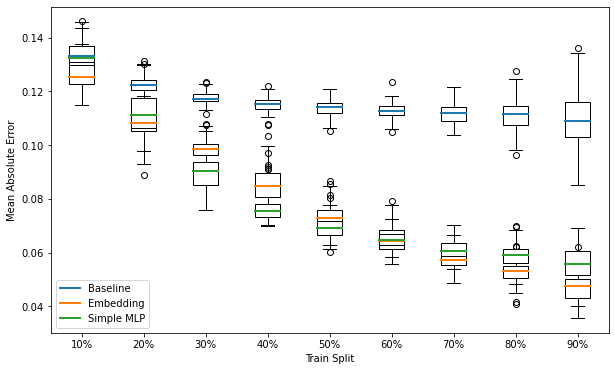

In [75]:
plots(["embedding", "simple_mlp"])

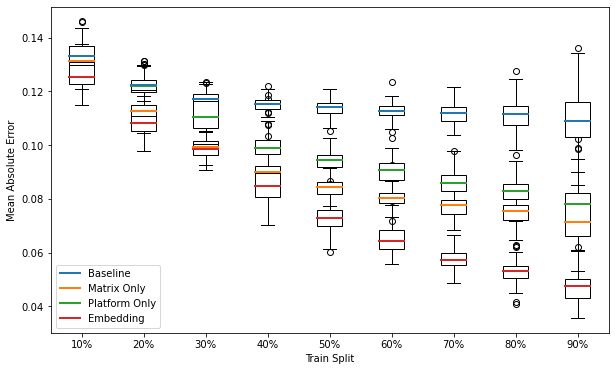

In [76]:
plots(["linear", "runtime_only", "embedding"])

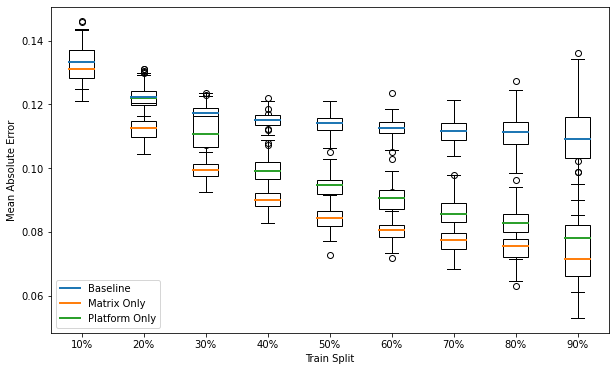

In [60]:
plots(["linear", "runtime_only"])

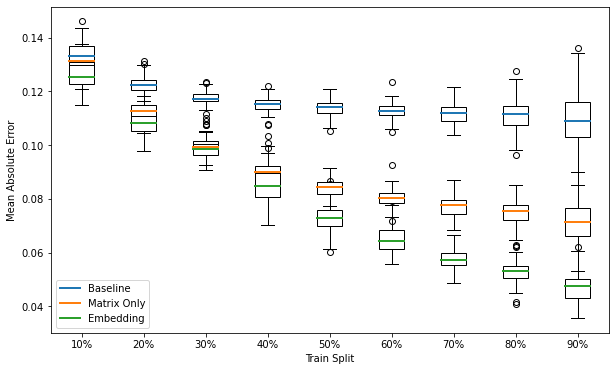

In [54]:
plots(["linear", "embedding"])

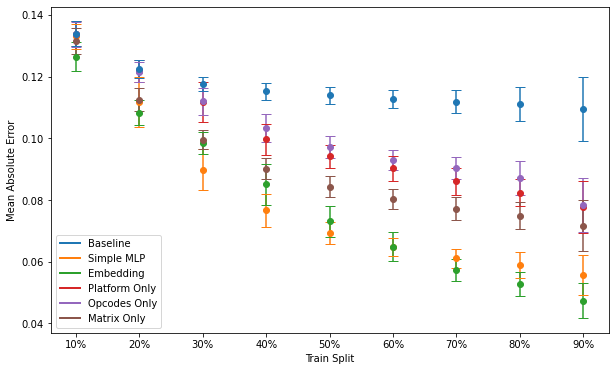

In [79]:
plots(["simple_mlp", "embedding", "runtime_only", "module_only", "linear"], style="error")

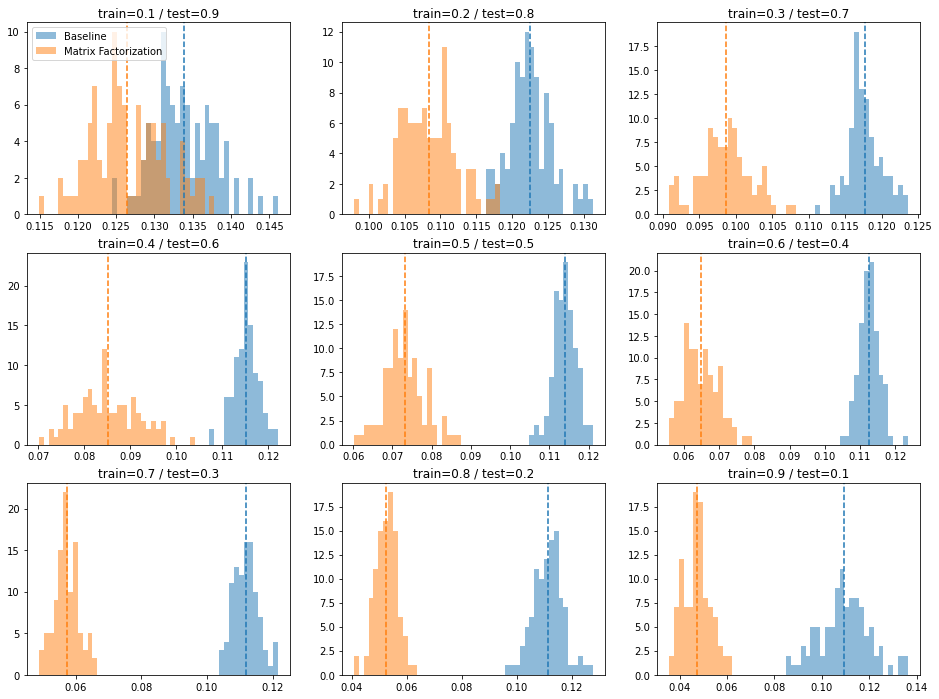

In [172]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

spval = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for ax, sp, res, comparison in zip(axs.reshape(-1), spval, results, comparisons):
    res.compare_plot(ax, comparison)
    ax.set_title("train={:.1f} / test={:.1f}".format(sp, 1 - sp))
axs[0, 0].legend(loc='upper left')

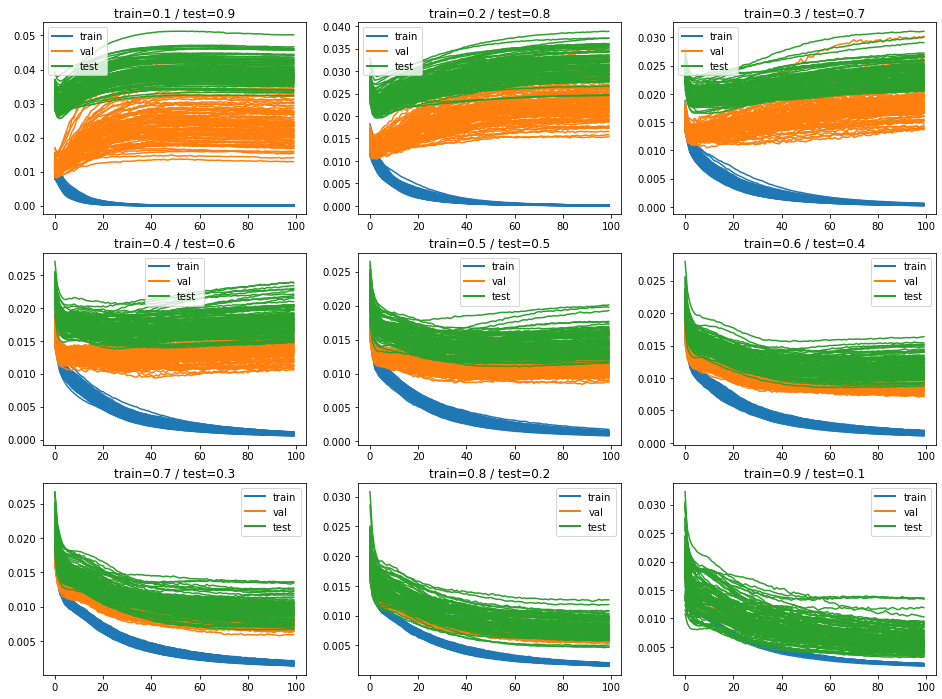

In [83]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

spval = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for ax, sp, res, comparison in zip(axs.reshape(-1), spval, results["embedding"], comparisons["embedding"]):
    res.plot_training(ax)
    ax.set_title("train={:.1f} / test={:.1f}".format(sp, 1 - sp))

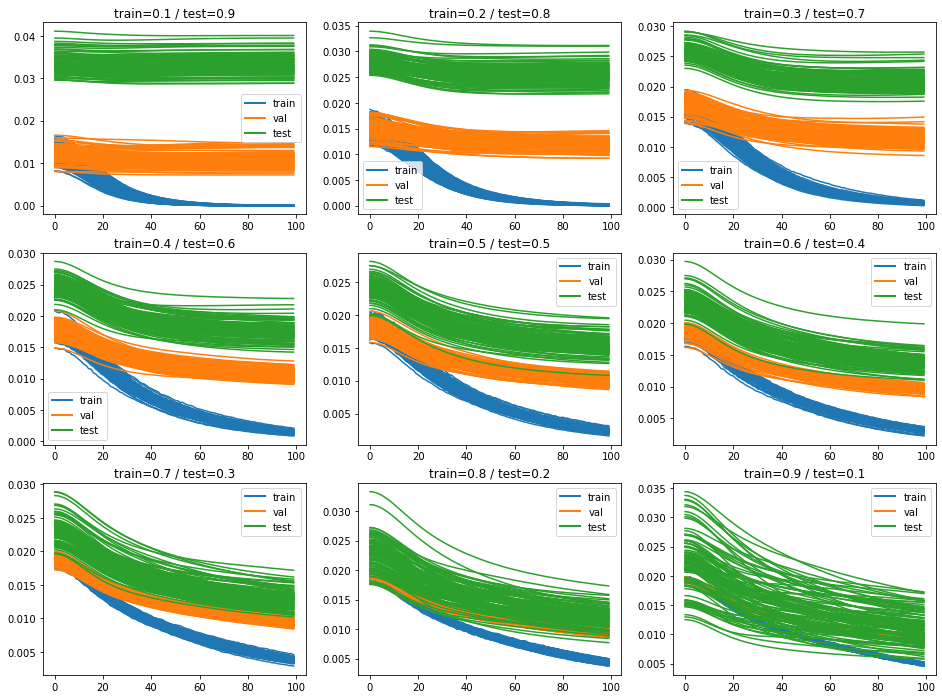

In [82]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

spval = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for ax, sp, res, comparison in zip(axs.reshape(-1), spval, results["linear"], comparisons["linear"]):
    res.plot_training(ax)
    ax.set_title("train={:.1f} / test={:.1f}".format(sp, 1 - sp))

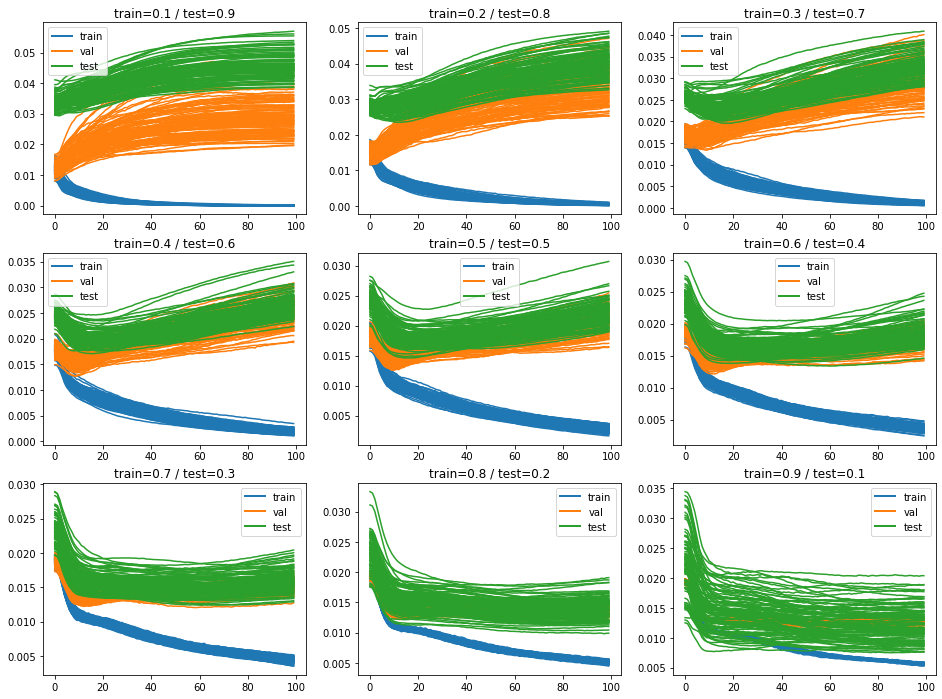

In [81]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

spval = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for ax, sp, res, comparison in zip(axs.reshape(-1), spval, results["module_only"], comparisons["module_only"]):
    res.plot_training(ax)
    ax.set_title("train={:.1f} / test={:.1f}".format(sp, 1 - sp))

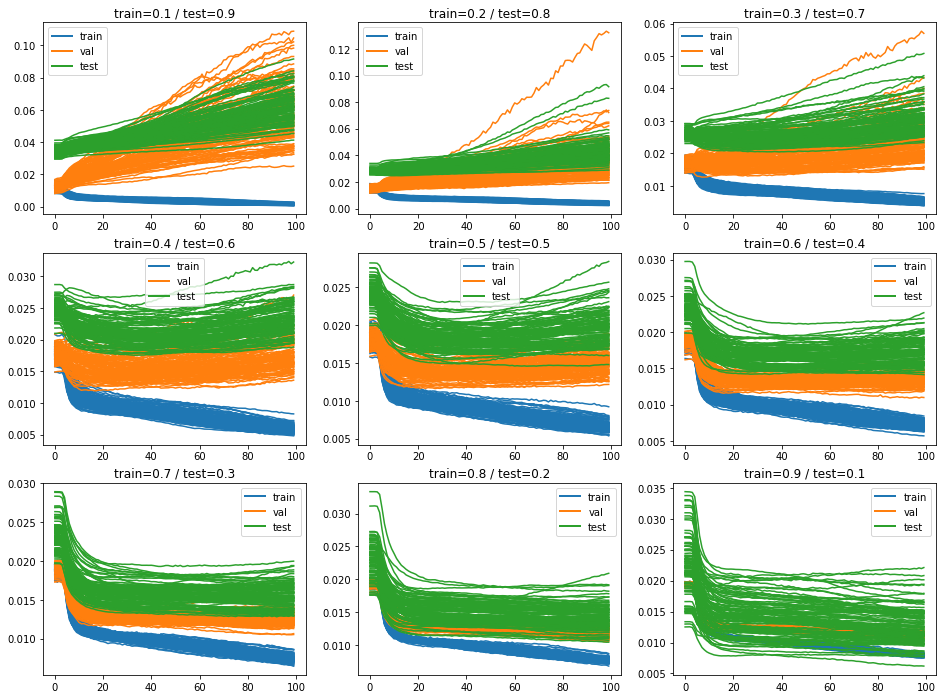

In [80]:
fig, axs = plt.subplots(3, 3, figsize=(16, 12))

spval = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for ax, sp, res, comparison in zip(axs.reshape(-1), spval, results["runtime_only"], comparisons["runtime_only"]):
    res.plot_training(ax)
    ax.set_title("train={:.1f} / test={:.1f}".format(sp, 1 - sp))